# Training a multi-linear classifier 

*In this assignment I had to train and test a one layer network with multiple outputs to classify images from the CIFAR-10 dataset. I trained the network using mini-batch gradient descent applied to a cost function that computes cross-entropy loss of the classifier applied to the labelled training data and an L2 regularization term on the weight matrix.*

In [0]:
#@title Installers
#installers if needed
#!pip install -U -q PyDrive
# !pip uninstall scipy
# !pip install scipy==1.2.0
# !pip install texttable

In [0]:
#@title Import libraries
#Import CIFAR-10 data from my google drive folder; I downoaded and unzipped the CIRAR-10 files and uploaded them to my drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
import pandas
import numpy
from texttable import Texttable
from sklearn.preprocessing import StandardScaler
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

from PIL import Image
import pickle
import numpy as np
from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

import io
from googleapiclient.http import MediaIoBaseDownload
import matplotlib.pyplot as plt

from scipy import misc #remove, using PIL instead

In [0]:
#@title Functions: Decoding and displaying images
def unpickle(file):
  dict = pickle.load(file, encoding='bytes')
  return dict

def unpickle_getFromDrive(file_id):
  filename = GetFromDrive(file_id)
  dict = pickle.load(filename, encoding='bytes')
  return dict 

def loadLabels(file_id):
  data = unpickle_getFromDrive(label_file)
  labels = [x.decode('ascii') for x in data[b'label_names']]
  return labels

def LoadBatch(file_id):
    filename = GetFromDrive(file_id)
    dataset = unpickle(filename)
    dataSamples = dataset[b'data'] / 255
    labels = dataset[b'labels']
    y = labels
    label_count = np.max(labels)
    X = dataSamples
    Y = np.array([[0 if labels[i] != j else 1 for j in range(label_count + 1)] for i in range(len(labels))])
    return X, Y, y

def GetFromDrive(file_id): 
    request = drive_service.files().get_media(fileId=file_id)
    downloaded = io.BytesIO()
    downloader = MediaIoBaseDownload(downloaded, request)
    done = False
    while done is False:
      _, done = downloader.next_chunk()
    downloaded.seek(0)
    return downloaded

def plot(tr_loss, val_loss, tr_accuracy, val_accuracy):
    plt.subplot(1,2,1)
    plt.plot(tr_loss, 'g-', label='training loss')
    plt.plot(val_loss, 'r-', label='validation loss')
    plt.title('Cost function')
    plt.xlabel('epoch')
    plt.ylabel('cost')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(tr_accuracy, 'g-', label='training data')
    plt.plot(val_accuracy, 'r-', label='validation data')
    plt.title('Accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()

    plt.show()

def image(img, label=''):
    sq_img = np.rot90(np.reshape(img, (32, 32, 3), order='F'), k=3)
    plt.imshow(sq_img, interpolation='gaussian')
    plt.axis('off')
    plt.title(label)

def showImageFromWeightsWithLabels(W, labels):
    for i, row in enumerate(W):
        img = (row - row.min()) / (row.max() - row.min())
        plt.subplot(2, 5, i+1)
        image(img, label=labels[i])
    plt.show()

EXERCISE 1. PART 1.

*Read in and store the training, validation and test data*

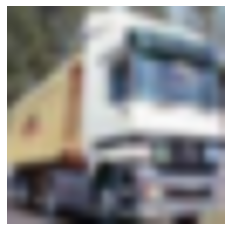

In [0]:
#@title Code: Load training-, validation- and test- data
#string are my file-id.s from my drive
#(you need exchange these with your own ids)
data_batch_1 = '1'
data_batch_2 = '2'
data_batch_3 = '3'
data_batch_4 = '4'
data_batch_5 = '5'
test_batch = '6'
label_file = '7'

# Read in and store the training, validation and test data 
labels = loadLabels(label_file)
X_train, Y_train, y_train = LoadBatch(data_batch_1) 
X_val, Y_val, y_val = LoadBatch(data_batch_2) 
X_test, Y_test, y_test = LoadBatch(test_batch) 
image(X_train[1])

EXERCISE 1. PART 2.

*Transform training data to have zero mean*

In [0]:
#@title Functions: Normalize data
def getNormalized(X):
    m = np.mean(X, axis = 0)
    return (X - m, m)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


X_train mean: 1.7869613196571282e-15
X_val mean: -0.0008092555147040919
X_test mean: 0.0019141973039233557


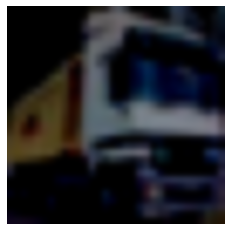

In [0]:
#@title Code: Normalize data
X_train, normalMeans = getNormalized(X_train)
X_test -= normalMeans 
X_val -= normalMeans 
image(X_train[1])

print("X_train mean: " + str(np.mean(X_train)))
print("X_val mean: " + str(np.mean(X_val)))
print("X_test mean: " + str(np.mean(X_test)))

EXERCISE 1. PART 3.

*Initialize parameters of the model W and b with entry to have Gaussian random values (incl. zero mean and standard deviation of .01)*

In [0]:
mean = 0.0
s = 0.01
d = X_train.shape[1] 
K = Y_train.shape[1] 
W = np.random.normal(mean, s, (K, d)) # Weight matrix; Normal (Gaussian) distribution
b = np.random.normal(mean, s, (K, 1)) # Bias vector; Normal (Gaussian) distribution

EXERCISE 1. PART 4.

*Function that evaluates the network function*

In [0]:
#@title Functions: EvaluateClassifier and Softmax
#Data size, per batch contains a dic
#with data structre 10000*3072 and an RGB array 32*32*3, 
#where labels are of size 10000numbers in range 0-9 i.e. 10labels

def EvaluateClassifier(X, W, b): 
  P = softmax(np.dot(W, X.T) + b)
  return P

def softmax(s):
    return np.exp(s) / np.sum(np.exp(s), axis=0)

In [0]:
P = EvaluateClassifier(X_train[:100], W, b) #Check subset
np.sum(P, axis = 0) # Check if the sums for each sample sum up to 1

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

EXERCISE 1. PART 5.

*Function that computes the cost function*

In [0]:
#@title Functions: Compute Cost and Cross Entropy Loss 
def CrossEntropyLoss(X, Y, W, b):
    log_X = np.multiply(Y.T , EvaluateClassifier(X,W,b)).sum(axis=0)
    log_X[log_X == 0] = np.finfo(float).eps
    return -np.log(log_X)
    
def ComputeCost(X, Y, W, b, lamda, scale_const = 1e+6):
    return np.mean(scale_const * CrossEntropyLoss(X, Y, W, b)) / scale_const \
            + lamda * np.sum(scale_const * np.power(W, 2)) / scale_const


In [0]:
J = ComputeCost(X_train, Y_train, W, b, lamda = 0)
print("Loss from Cost Function: " + str(J))

Loss from Cost Function: 2.32091356491174


EXERCISE 1. PART 6.

*Function that computes the accuracy*

In [0]:
#@title Functions: Compute Accuracy
def ComputeAccuracy(X, y, W, b): 
    predictions = np.argmax(EvaluateClassifier(X,W,b) , axis = 0)
    accuracy = (predictions == y).mean()
    return accuracy 

In [0]:
acc = ComputeAccuracy(X_train, y_train, W, b) 
print("Check accuracy: " + str(acc))

Check accuracy: 0.0898


EXERCISE 1. PART 7.

*Function that evaluates, for a mini-batch, the gradients, of the cost function w.r.t. W and b*

In [0]:
#@title Functions: Compute gradients and display differences between methods
# Check Check analytic gradient computations against numerical estimations of the gradients!
class FFNet():    #Feed Forward Neural Network, Single Layer    
    def __init__(self, d, K, mean, s):
        self.d = d
        self.K = K
        self.W = np.random.normal(mean, s, (K, d)) 
        self.b = np.random.normal(mean, s, (K, 1)) 

    def computeGradsNum(self, X, Y, lamda, h = 1e-8): #finite difference method =  Faster but less accurate calculation of the gradients
        # return (grad_W, grad_b)
        P = EvaluateClassifier(X, self.W, self.b)
        """ Converted from matlab code """
        no 	= 	self.W.shape[0]
        d 	= 	X.shape[0]

        grad_W = np.zeros(self.W.shape);
        grad_b = np.zeros((no, 1));

        c = ComputeCost(X, Y, self.W, self.b, lamda);
        
        for i in range(len(self.b)):
          b_try = np.array(self.b)
          b_try[i] += h
          c2 = ComputeCost(X, Y, self.W, b_try, lamda)
          grad_b[i] = (c2-c) / h

        for i in range(self.W.shape[0]):
          for j in range(self.W.shape[1]):
            W_try = np.array(self.W)
            W_try[i,j] += h
            c2 = ComputeCost(X, Y, W_try, self.b, lamda)
            grad_W[i,j] = (c2-c) / h
        return [grad_W, grad_b]                

    def computeGradsNumSlow(self, X, Y, lamda, h = 1e-8): #Centered difference formula = More exact calculation of the gradients but slower
        """ Converted from matlab code """
        no 	= 	self.W.shape[0]
        d 	= 	X.shape[0]

        grad_W = np.zeros(self.W.shape);
        grad_b = np.zeros((no, 1));
        
        for i in range(len(self.b)):
          b_try = np.array(self.b)
          b_try[i] -= h
          c1 = ComputeCost(X, Y, self.W, b_try, lamda)

          b_try = np.array(self.b)
          b_try[i] += h
          c2 = ComputeCost(X, Y, self.W, b_try, lamda)

          grad_b[i] = (c2-c1) / (2*h)

        for i in range(self.W.shape[0]):
          for j in range(self.W.shape[1]):
            W_try = np.array(self.W)
            W_try[i,j] -= h
            c1 = ComputeCost(X, Y, W_try, self.b, lamda)

            W_try = np.array(self.W)
            W_try[i,j] += h
            c2 = ComputeCost(X, Y, W_try, self.b, lamda)

            grad_W[i,j] = (c2-c1) / (2*h)
        return [grad_W, grad_b]

    def computeAnalyticalGradients(self, X, Y, lamda): #Analytical computation of the gradient
        P = EvaluateClassifier(X, self.W, self.b)
        
        grad_W = np.zeros(self.W.shape)
        grad_b = np.zeros(self.b.shape)

        for i in range(X.shape[0]):
            x = X[i].reshape(1,-1)
            g = -(Y[i].reshape(-1,1) - EvaluateClassifier(x, self.W, self.b))
            grad_b += g
            grad_W += g.dot(x)
        grad_W /= X.shape[0]
        grad_W += self.W * 2 * lamda
        grad_b /= X.shape[0]
        return (grad_W, grad_b)

def relErr(grad1, grad2):
    rel_err = np.abs(grad1 - grad2)  / (np.abs(grad1) + np.abs(grad2))
    return rel_err*100*100
  
def absErr(grad1, grad2):
    abs_err = np.abs(grad1 - grad2) 
    return abs_err*100*100*100

def compareGradients(lamda, title):
  samples = 100
  FFnet = FFNet(d, K, mean, s)

  grad_W1, grad_b1 = FFnet.computeAnalyticalGradients(X_train[:samples, :d], Y_train[:samples],  lamda)
  grad_W2, grad_b2 = FFnet.computeGradsNum(X_train[:samples, :d], Y_train[:samples],  lamda)
  grad_W3, grad_b3 = FFnet.computeGradsNumSlow(X_train[:samples, :d], Y_train[:samples],  lamda)

  err = Texttable()
  err_data = [] 

  # Compare accurate numerical method with analytical estimation of gradient
  err_data.append(['Gradient', 'Method', 'Rel Diff Min [e+04]', 'Rel Diff Max [e+04]', 'Rel Diff Mean [e+04]', 'Abs Diff Max [e+06]', 'Abs Diff Mean [e+06]'])

  cdm_err_W = relErr(grad_W1, grad_W3)
  cdm_err_b = relErr(grad_b1, grad_b3)
  cdm_err_W_abs = absErr(grad_W1, grad_W3)
  cdm_err_b_abs = absErr(grad_b1, grad_b3)

  fdm_err_W = relErr(grad_W1, grad_W2)
  fdm_err_b = relErr(grad_b1, grad_b2)
  fdm_err_W_abs = absErr(grad_W1, grad_W2)
  fdm_err_b_abs = absErr(grad_b1, grad_b2)

  cdm_fdm_err_W=  relErr(grad_W2, grad_W3)
  cdm_fdm_err_b=  relErr(grad_b2, grad_b3)
  cdm_fdm_err_W_abs =  absErr(grad_W2, grad_W3)
  cdm_fdm_err_b_abs =  absErr(grad_b2, grad_b3)

  err_data.append(["W", "ANL vs CDM", str(np.min(cdm_err_W)),str(np.max(cdm_err_W)),str(np.mean(cdm_err_W)),str(np.max(cdm_err_W_abs)),str(np.mean(cdm_err_W_abs))])
  err_data.append(["W", "ANL vs FDM", str(np.min(fdm_err_W)),str(np.max(fdm_err_W)),str(np.mean(fdm_err_W)),str(np.max(fdm_err_W_abs)),str(np.mean(fdm_err_W_abs))])
  err_data.append(["W", "CDM vs FDM", str(np.min(cdm_fdm_err_W)),str(np.max(cdm_fdm_err_W)),str(np.mean(cdm_fdm_err_W)),str(np.max(cdm_fdm_err_W_abs)),str(np.mean(cdm_fdm_err_W_abs))])


  err_data.append(["b", "ANL vs CDM", str(np.min(cdm_err_b)),str(np.max(cdm_err_b)),str(np.mean(cdm_err_b)),str(np.max(cdm_err_b_abs)),str(np.mean(cdm_err_b_abs))])
  err_data.append(["b", "ANL vs FDM", str(np.min(fdm_err_b)),str(np.max(fdm_err_b)),str(np.mean(fdm_err_b)),str(np.max(fdm_err_b_abs)),str(np.mean(fdm_err_b_abs))])
  err_data.append(["b", "CDM vs FDM", str(np.min(cdm_fdm_err_b)),str(np.max(cdm_fdm_err_b)),str(np.mean(cdm_fdm_err_b)),str(np.max(cdm_fdm_err_b_abs)),str(np.mean(cdm_fdm_err_b_abs))])

  err.add_rows(err_data)
  print(title)
  print(err.draw())    

Analytical (ANL) gradient computation is in the following result compared to the slow but accurate version based on the centered difference equation (CDM) and compared to the faster but less accurate finite difference method (FDM). The accuracy can be observed in the observed in the below tables which displays relative and absolute differences between the aformentioned methods. Note that absolute differences are less than 1e-6 and thereby considered to have produced the same result.  

In [0]:
compareGradients(lamda=0.0, title="Without Regularization i.e. Lambda = 0.0")

Without Regularization i.e. Lambda = 0.0
+----------+-----------+-----------+----------+----------+----------+----------+
| Gradient |  Method   | Rel Diff  | Rel Diff | Rel Diff | Abs Diff | Abs Diff |
|          |           |    Min    |   Max    |   Mean   |   Max    |   Mean   |
|          |           |  [e+04]   |  [e+04]  |  [e+04]  |  [e+06]  |  [e+06]  |
+==========+===========+===========+==========+==========+==========+==========+
| W        | ANL vs    | 0.000     | 547.345  | 0.104    | 0.081    | 0.016    |
|          | CDM       |           |          |          |          |          |
+----------+-----------+-----------+----------+----------+----------+----------+
| W        | ANL vs    | 0.000     | 1468.733 | 0.317    | 0.158    | 0.046    |
|          | FDM       |           |          |          |          |          |
+----------+-----------+-----------+----------+----------+----------+----------+
| W        | CDM vs    | 0         | 2000     | 0.315    | 0.111    

In [0]:
compareGradients(lamda=1.0, title="With Regularization i.e. Lambda = 1.0")

With Regularization i.e. Lambda = 1.0
+----------+-----------+-----------+----------+----------+----------+----------+
| Gradient |  Method   | Rel Diff  | Rel Diff | Rel Diff | Abs Diff | Abs Diff |
|          |           |    Min    |   Max    |   Mean   |   Max    |   Mean   |
|          |           |  [e+04]   |  [e+04]  |  [e+04]  |  [e+06]  |  [e+06]  |
+==========+===========+===========+==========+==========+==========+==========+
| W        | ANL vs    | 0.000     | 85.277   | 0.051    | 0.125    | 0.027    |
|          | CDM       |           |          |          |          |          |
+----------+-----------+-----------+----------+----------+----------+----------+
| W        | ANL vs    | 0.000     | 185.524  | 0.078    | 0.178    | 0.039    |
|          | FDM       |           |          |          |          |          |
+----------+-----------+-----------+----------+----------+----------+----------+
| W        | CDM vs    | 0         | 204.082  | 0.047    | 0.089    | 0

EXERCISE 1. PART 8.

*Function that performs the mini-batch gradient descent algorithm to learn the network's parameters*

As the below result shows, after the first epoch the cost score decreases and the accuracy increases for each epoch.

Learning rate: We can also tell from the same result, that when the learning rate (eta) is too large, the training of the model becomes unstable. This can be observed in the first figure where eta=0.1

Regularization: The effect on accuracy when applying regularization is that it is narrower between the training data and validation data in difference to when not applying it. However, without regularization the accuracy is higher. Ideal is it not to have it too wide as this can be an indication of overfitting on the training data.

In [0]:
#@title Function: Mini-batch gradient descent
class FFNet_mbGD(FFNet):
    def miniBatchGD(self, X, Y, n_batch, eta, n_epochs ,  lamda, X_val = None, Y_val = None):
        results = ([],[],[],[])
        miniBatchNo = X.shape[0] // n_batch
        
        results[0].append(ComputeCost(X, Y,self.W, self.b, lamda))
        results[1].append(ComputeCost(X_val, Y_val,self.W, self.b, lamda))
        results[2].append(ComputeAccuracy(X, np.argmax(Y.T, axis = 0),self.W, self.b))
        results[3].append(ComputeAccuracy(X_val, np.argmax(Y_val.T, axis = 0),self.W, self.b))
                
        for i in range(n_epochs):
            for j in range(miniBatchNo):
                if(j >= miniBatchNo - 1):
                    Xbatch = X[j * n_batch:]
                    Ybatch = Y[j * n_batch:]
                else:
                    j_start = j * n_batch
                    j_end = j_start + n_batch
                    Xbatch = X[j_start:j_end]
                    Ybatch = Y[j_start:j_end]
                grad_W, grad_b = self.computeAnalyticalGradients(Xbatch, Ybatch,lamda)
                self.W -= eta * grad_W
                self.b -= eta * grad_b

            results[0].append(ComputeCost(X, Y, self.W, self.b, lamda)) 
            results[1].append(ComputeCost(X_val, Y_val,self.W, self.b, lamda))
            results[2].append(ComputeAccuracy(X, np.argmax(Y.T, axis = 0),self.W, self.b))
            results[3].append(ComputeAccuracy(X_val, np.argmax(Y_val.T, axis = 0),self.W, self.b))
        return results

****************************************
lambda=0, n epochs=40, n batch=100, eta=0.1
****************************************


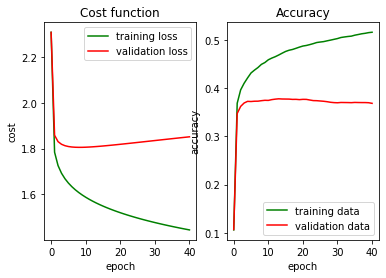

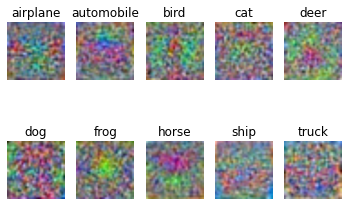

****************************************
lambda=0, n epochs=40, n batch=100, eta=0.001
****************************************


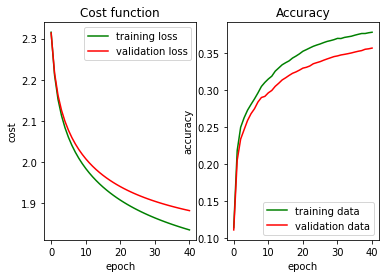

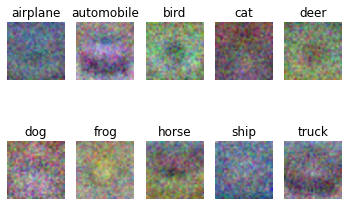

****************************************
lambda=0.1, n epochs=40, n batch=100, eta=0.001
****************************************


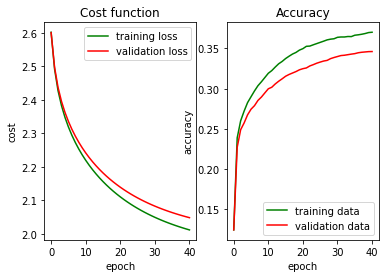

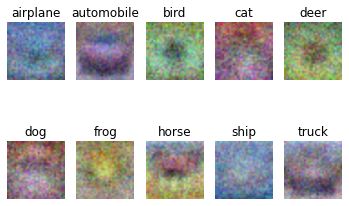

****************************************
lambda=1, n epochs=40, n batch=100, eta=0.001
****************************************


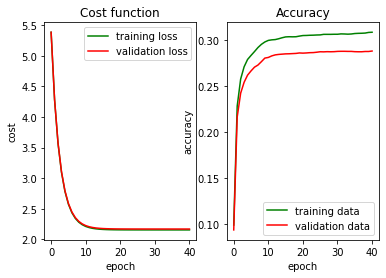

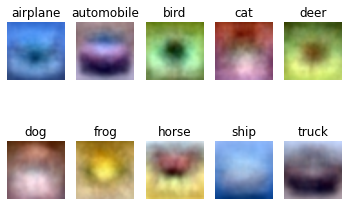

+------------------------------+----------------+--------------+---------------+
|          Parameters          | Train Accuracy | Val Accuracy | Test Accuracy |
+==============================+================+==============+===============+
| lambda=0, n epochs=40, n     | 0.516          | 0.368        | 0.372         |
| batch=100, eta=0.1           |                |              |               |
+------------------------------+----------------+--------------+---------------+
| lambda=0, n epochs=40, n     | 0.378          | 0.356        | 0.362         |
| batch=100, eta=0.001         |                |              |               |
+------------------------------+----------------+--------------+---------------+
| lambda=0.1, n epochs=40, n   | 0.370          | 0.346        | 0.355         |
| batch=100, eta=0.001         |                |              |               |
+------------------------------+----------------+--------------+---------------+
| lambda=1, n epochs=40, n  

In [0]:
#@title Code: Run mini-batch gradient descent with difference parameters
# Train for the following parameters
lambdas = [0, 0, .1, 1]
etas = [.1, .001, .001, .001] 
n_batch = 100
n_epochs = 40
np.random.seed(400) #400 specified in the assignment

t = Texttable()
data = [] 
data.append(['Parameters', 'Train Accuracy', 'Val Accuracy', 'Test Accuracy'])

for x in range(0, len(lambdas)):
  nm = FFNet_mbGD(d = X_train.shape[1], K = Y_train.shape[1], mean = 0.0, s = 0.01)
  tr_loss, val_loss, tr_accuracy, val_accuracy = nm.miniBatchGD(
      X_train, Y_train, 
      n_batch, etas[x], n_epochs, lambdas[x],
      X_val = X_val, Y_val = Y_val)
  saveFortbl = "lambda="+str(lambdas[x])+", n epochs="+str(n_epochs)+", n batch="+str(n_batch)+", eta="+str(etas[x])+""
  print("****************************************")
  print("lambda="+str(lambdas[x])+", n epochs="+str(n_epochs)+", n batch="+str(n_batch)+", eta="+str(etas[x])+"")
  print("****************************************")
  data.append([saveFortbl,str(tr_accuracy[-1]), str(val_accuracy[-1]),str(ComputeAccuracy(X_test, y_test, nm.W, nm.b))])
  plot(tr_loss, val_loss, tr_accuracy, val_accuracy)
  showImageFromWeightsWithLabels(nm.W, labels)
t.add_rows(data)
print(t.draw())
print(" ")
